In [23]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34669,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:46767,Total threads: 4
Dashboard: /proxy/39413/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:34619,


In [8]:
%%time
CSHT_rho_bins = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')
U_along_rho_bins = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_speed/daily_rho/WMbins_daily_rho/*')

CPU times: user 23.3 s, sys: 5.37 s, total: 28.6 s
Wall time: 28.2 s


In [18]:
CSHT_rho_bins

<xarray.Dataset> Size: 15GB
Dimensions:                              (time: 22280, potrho0: 8,
                                          lon_bin_midpoints: 1428,
                                          contour_index: 6002)
Coordinates:
  * time                                 (time) datetime64[ns] 178kB 1958-01-...
  * potrho0                              (potrho0) float64 64B 13.8 ... 40.0
  * contour_index                        (contour_index) int64 48kB 1 2 ... 6002
  * lon_bin_midpoints                    (lon_bin_midpoints) float64 11kB -27...
Data variables:
    zonal_convergence                    (time, potrho0, lon_bin_midpoints) float64 2GB dask.array<chunksize=(31, 8, 1428), meta=np.ndarray>
    binned_cross_slope_heat_trans        (time, potrho0, lon_bin_midpoints) float64 2GB dask.array<chunksize=(31, 8, 1428), meta=np.ndarray>
    unbinned_heat_transp_across_contour  (time, potrho0, contour_index) float64 9GB dask.array<chunksize=(31, 8, 6002), meta=np.ndarray>
    lat_along_contour                    (time, contour_index) float64 1GB dask.array<chunksize=(31, 6002), meta=np.ndarray>
    lon_along_contour                    (time, contour_index) float64 1GB dask.array<chunksize=(31, 6002), meta=np.ndarray>
    lat_bin_midpoints                    (time, lon_bin_midpoints) float64 255MB dask.array<chunksize=(31, 1428), meta=np.ndarray>

In [9]:
CSHTtotal = CSHT_rho_bins.binned_cross_slope_heat_trans #+CSHT_rho_bins.zonal_convergence+

In [28]:
%%time
###### T-GRID ######

# Create an empty DataArray with the same shape as 'temp_avg'
full_CSHT_total = xr.full_like(CSHTtotal, np.nan)

# Assign the 1D st_ocean coordinate to the new DataArray, broadcasting along the other dimensions
full_CSHT_total.data = np.broadcast_to(full_CSHT_total.potrho0.values[np.newaxis, :, np.newaxis], full_CSHT_total.shape)
full_CSHT_total_masked = full_CSHT_total*CSHTtotal/CSHTtotal # Here, we mask by temp_avg to ensure the Nans are preserved 

# Now 'full_st_ocean_t_masked' is a 3D DataArray with 'st_ocean' values broadcasted along yt_ocean and xt_ocean
# and masked by temp_avg

# Find the bottom depth for each (yt_ocean, xt_ocean) coordinate
max_rho = full_CSHT_total_masked.max(dim='potrho0').compute().rename('max_rho')
min_rho = full_CSHT_total_masked.min(dim='potrho0').compute().rename('min_rho')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 1.90 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:

CPU times: user 42.3 s, sys: 21.4 s, total: 1min 3s
Wall time: 1min 7s


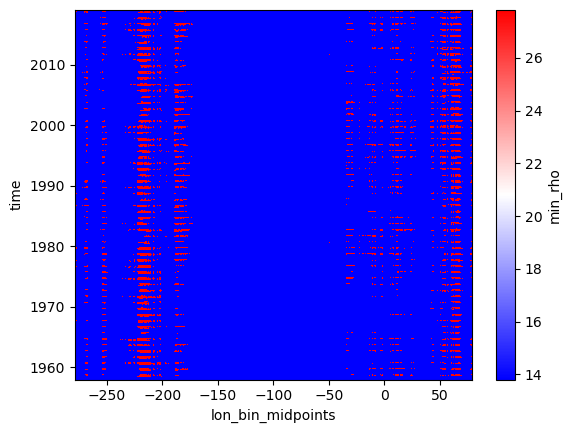

In [31]:
min_rho.plot(cmap=plt.cm.bwr)

In [ ]:
max_rho.plot(vmin=27, vmax=28, cmap=plt.cm.bwr)

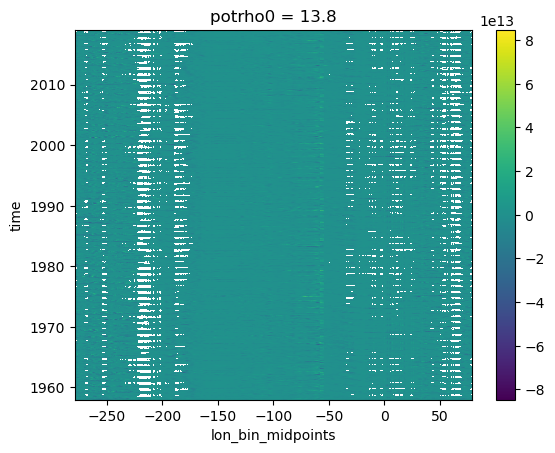

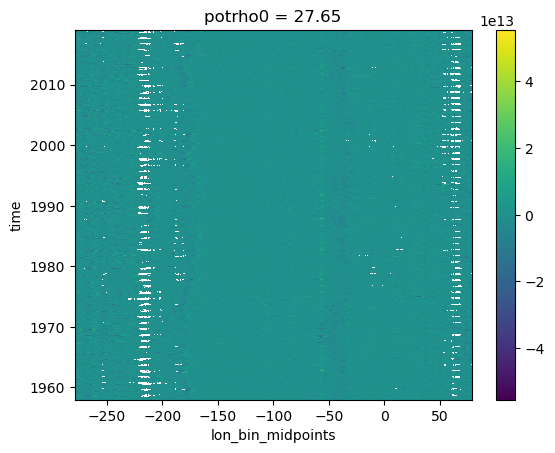

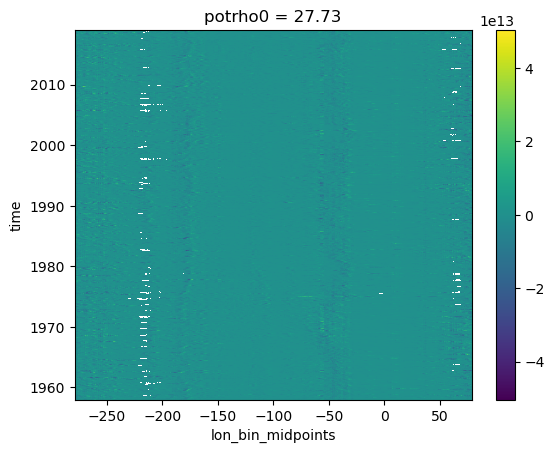

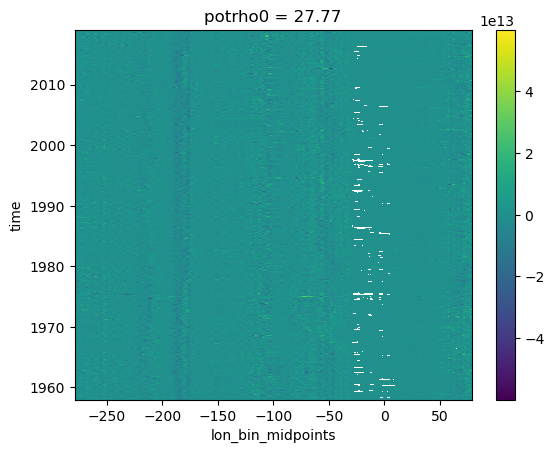

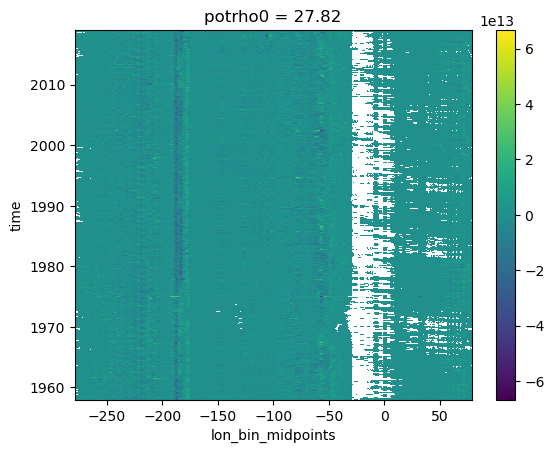

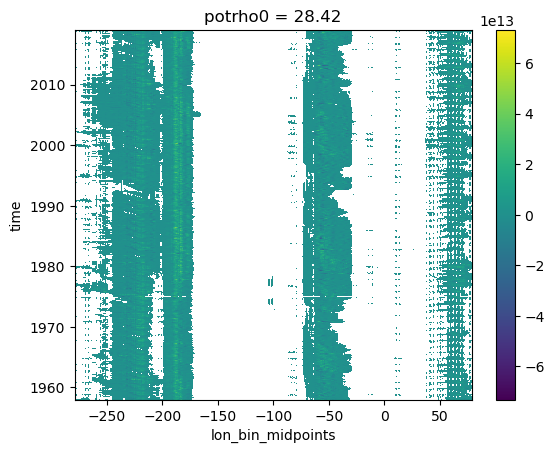

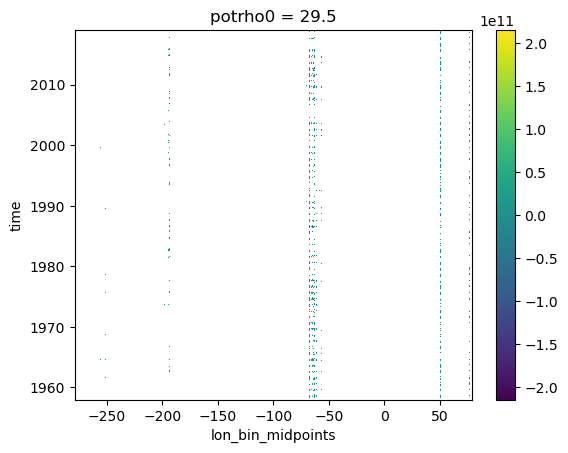

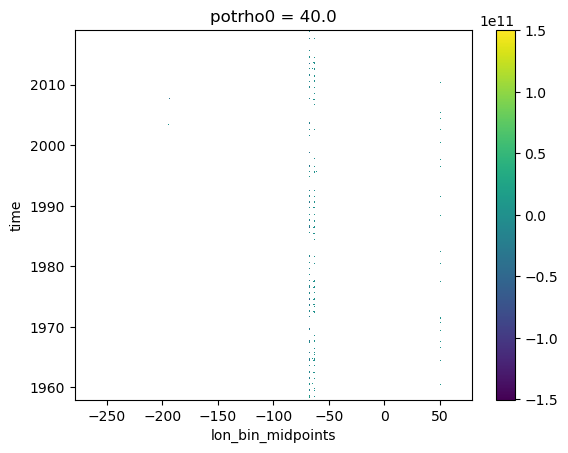

In [21]:
for i in range(8):
    CSHTtotal.where(CSHTtotal!=0).isel(potrho0=i).plot(cmap=plt.cm.viridis)
    plt.show()